In [1]:
from pathlib import Path

import gin
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from src.game import Game, CircleL1, CircleL2

In [2]:
def plot(logdir, savedir=None, name='error', show=True):
    if savedir:
        savepath = Path(savedir)
        
    logpath = Path(logdir)    

    config_file = next(logpath.glob('**/*.gin'))
    print(f'config file {config_file}')
    gin.parse_config_file(config_file, skip_unknown=True)
    
    bias = gin.config.query_parameter('Game.bias')
    num_points = gin.config.query_parameter('Game.num_points')
    test_loss = CircleL1(num_points)
    
    run_logs = []
    for path in logpath.glob('**/*.json'):
        print(f'plotting from {path}')
        with open(path, 'r') as logfile:
            run_logs.append(pd.read_json(logfile))

    logs = pd.concat(run_logs, ignore_index=True)
    sender = pd.DataFrame(logs['sender'].to_list()).join(logs['epoch'])
    recver = pd.DataFrame(logs['recver'].to_list()).join(logs['epoch'])
    
    if show:
        metric = "test_l1_error" if "test_l1_error" in sender else "test_error"

        # Rewards
        sns.lineplot(data=sender, x="epoch", y=sender[metric]*10, label="sender")
        sns.lineplot(data=recver, x="epoch", y=recver[metric]*10, label="receiver")

        # Baselines
        nocomm_diff = torch.tensor(36 / 4)
        nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
        fair_error = test_loss(torch.tensor(0.), bias/2)*10
        plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
        plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))

        plt.ylabel(r'Test $L_1$ loss')

        if savedir:
            plt.savefig(savepath / f'{name}.png',  bbox_inches='tight')
            
        print("here")
        plt.show()
        plt.clf()

    error_sum = pd.DataFrame(sender['test_l1_error'] + recver['test_l1_error']).join(logs['epoch'])
    error_20 = error_sum[error_sum['epoch'] >= 20]
    return [error_20[i*10:i*10+10]['test_l1_error'].mean() for i in range(5)]
    

    
def plot_hyperparam_results(results_dir, label=None, savepath=None, show=True):
    results_path = Path(results_dir)
    results = pd.read_csv(results_path / 'results.csv')
    
#     sns.lineplot(data=results, x=results['bias']*10, y=results['l1']*10, label=label)
#     plt.plot(results['bias']*10, results['bias']*10, label=r'optimal $L_1$ loss', color="grey", dashes=(2,2,2,2))

    
#     plt.axhline(torch.tensor(2 *(9**2)), label='no communication', color="black", dashes=(2,2,2,2))
#     sns.lineplot(data=results, x=results['bias'], y=results['error'], label=label)
# #     plt.plot(results['bias']*10, results['bias']*10, label=r'optimal $L_1$ loss', color="grey", dashes=(2,2,2,2))
#     plt.ylabel(r'Test $L_{2s}$ + $L_{2r}$')
#     plt.legend()
#     if savepath is not None:
#         savepath.mkdir(exist_ok=True)
#         plt.savefig(savepath / f'{results_path.name}-all.png',  bbox_inches='tight')
#     plt.show()
#     plt.clf()
    df = pd.DataFrame()
    df = df.append([results]*5, ignore_index=True)   
    seed_scores = []
    for bias, score, run_id, l1 in results.sort_values('bias').itertuples(index=False):
        print(f'bias {bias} run_id {run_id} score {score} l1 {l1}')
        try:
            logdir = list(results_path.glob(f'*{bias}_{run_id}*'))[0]
            seed_scores.extend(plot(logdir, savepath, f'{results_path.name}-bias{bias}', show=show))            
        except Exception as e:
            print(f'logdir not found for bias {bias}')
            print(f'Exception {e}')
#         plt.title(f'Bias {bias}')
    

    df.sort_values('bias', inplace=True)
    df.insert(2, 'seed_score', seed_scores)
    
    if show:
        plt.axhline(torch.tensor(360 / 2), label='no communication', color="black", dashes=(2,2,2,2))
        
    sns.lineplot(data=df, x=df['bias']*10, y=df['seed_score']*10, label=label)
    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.legend()
    if savepath is not None:
        savepath.mkdir(exist_ok=True)
        plt.savefig(savepath / f'{results_path.name}-all.png',  bbox_inches='tight')
    
    if show:
        plt.show()
        plt.clf()
    
    return df

bias 0 run_id 8db10d3d064872fb1f82c05970a3ab84 score 28.279436225891107 l1 6.333625707626343
config file ../results/cat-deter/cat-deter-bias0_8db10d3d064872fb1f82c05970a3ab84/3/config.gin
plotting from ../results/cat-deter/cat-deter-bias0_8db10d3d064872fb1f82c05970a3ab84/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_8db10d3d064872fb1f82c05970a3ab84/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_8db10d3d064872fb1f82c05970a3ab84/2/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_8db10d3d064872fb1f82c05970a3ab84/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_8db10d3d064872fb1f82c05970a3ab84/0/logs.json
bias 3 run_id 5f08b0fafa7182df3e8d9e1acc113b5e score 29.15425771713257 l1 6.235854959487915
config file ../results/cat-deter/cat-deter-bias3_5f08b0fafa7182df3e8d9e1acc113b5e/3/config.gin
plotting from ../results/cat-deter/cat-deter-bias3_5f08b0fafa7182df3e8d9e1acc113b5e/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias

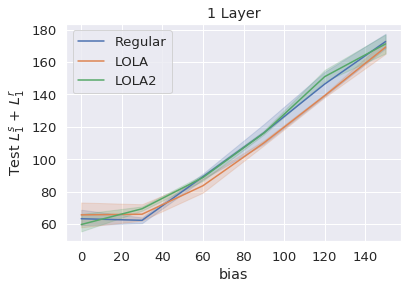

In [9]:

# basic_path = Path('../results/cat-deter-grounded')
# results = pd.read_csv(basic_path / 'results.csv')
# sns.lineplot(data=results, x='bias', y='l1', label='gauss-deter-grounded')

# lola_path = Path('../results/iclr/cat-deter')
# results = pd.read_csv(lola_path / 'results.csv')
# results['bias'] = results['bias'] * 10
# results['l1'] = results['l1'] * 10
# sns.lineplot(data=results, x='bias', y='l1', label='3 layer')

# results['optimal'] = results['bias'] + 36 / (4 * 256)
# sns.lineplot(data=results, x='bias', y='optimal', label='Optimal')

# logpath = '../results/marg-deter'
resultspath = Path('../results/cat-deter')
lolapath = Path('../results/senderlola1-recverlola1')
lola2path = Path('../results/senderlola2-recverlola2')


with sns.plotting_context('paper'):
    sns.set(font_scale=1.2)

    plt.title(f'1 Layer')
    plot_hyperparam_results(resultspath, 'Regular', resultspath / 'plots', show=False)
    plot_hyperparam_results(lolapath, 'LOLA', resultspath / 'plots', show=False)
    plot_hyperparam_results(lola2path, 'LOLA2', resultspath / 'plots', show=False)



bias 0 run_id 9c3f75e44837f864e6973606d3fa48ad score 29.756120223999034 l1 6.571321115493773
config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_9c3f75e44837f864e6973606d3fa48ad/3/config.gin
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_9c3f75e44837f864e6973606d3fa48ad/3/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_9c3f75e44837f864e6973606d3fa48ad/4/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_9c3f75e44837f864e6973606d3fa48ad/2/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_9c3f75e44837f864e6973606d3fa48ad/1/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_9c3f75e44837f864e6973606d3fa48ad/0/logs.json
bias 3 run_id c9f626abf740da59df9ccf0097d308b5 score 32.76480848312379 l1 6.612206649780274
config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-b

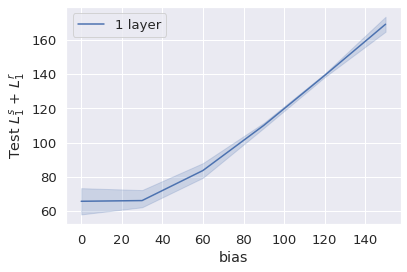

In [6]:
resultspath = Path('../results/senderlola1-recverlola1')

with sns.plotting_context('paper'):
    sns.set(font_scale=1.2)

#     plt.title(f'LOLA-{i}')
#     plot(logpath)
    plot_hyperparam_results(resultspath, '1 layer', resultspath / 'plots', show=False)

bias 0 run_id f04f33df38cd4ed3e69482dd85907048 score 1.3753189039230338 l1 1.3753189039230338
config file ../results/cat-deter-l1/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/0/config.gin
plotting from ../results/cat-deter-l1/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/0/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/1/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/4/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/3/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/2/logs.json


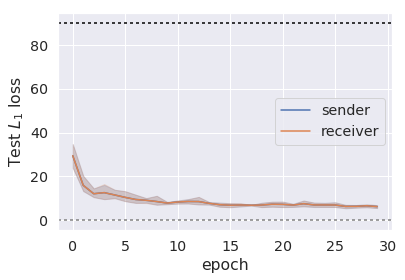

bias 3 run_id b9943073309d9e9fadd5957e148c0c46 score 9.791334295272828 l1 9.791334295272828
config file ../results/cat-deter-l1/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/0/config.gin
plotting from ../results/cat-deter-l1/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/0/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/1/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/4/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/3/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/2/logs.json


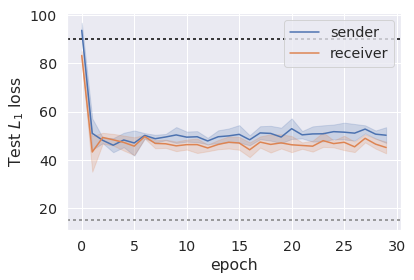

bias 6 run_id 335997298bbccd4ed65136267d4571eb score 14.24613522529602 l1 14.24613522529602
config file ../results/cat-deter-l1/cat-deter-bias6_335997298bbccd4ed65136267d4571eb/0/config.gin
plotting from ../results/cat-deter-l1/cat-deter-bias6_335997298bbccd4ed65136267d4571eb/0/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias6_335997298bbccd4ed65136267d4571eb/1/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias6_335997298bbccd4ed65136267d4571eb/4/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias6_335997298bbccd4ed65136267d4571eb/3/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias6_335997298bbccd4ed65136267d4571eb/2/logs.json


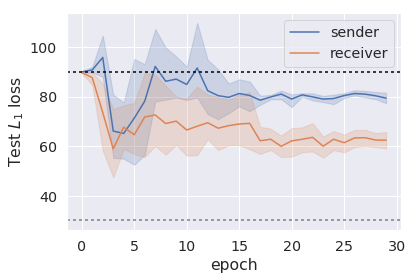

bias 9 run_id 9bf407970f6b0b9eec17d92cbb8f755f score 16.59253533363342 l1 16.59253533363342
config file ../results/cat-deter-l1/cat-deter-bias9_9bf407970f6b0b9eec17d92cbb8f755f/0/config.gin
plotting from ../results/cat-deter-l1/cat-deter-bias9_9bf407970f6b0b9eec17d92cbb8f755f/0/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias9_9bf407970f6b0b9eec17d92cbb8f755f/1/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias9_9bf407970f6b0b9eec17d92cbb8f755f/4/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias9_9bf407970f6b0b9eec17d92cbb8f755f/3/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias9_9bf407970f6b0b9eec17d92cbb8f755f/2/logs.json


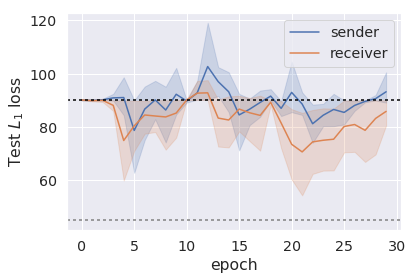

bias 12 run_id 01fd084cc1e8d94744162882ac36e320 score 17.407645874023434 l1 17.407645874023434
config file ../results/cat-deter-l1/cat-deter-bias12_01fd084cc1e8d94744162882ac36e320/0/config.gin
plotting from ../results/cat-deter-l1/cat-deter-bias12_01fd084cc1e8d94744162882ac36e320/0/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias12_01fd084cc1e8d94744162882ac36e320/1/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias12_01fd084cc1e8d94744162882ac36e320/4/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias12_01fd084cc1e8d94744162882ac36e320/3/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias12_01fd084cc1e8d94744162882ac36e320/2/logs.json


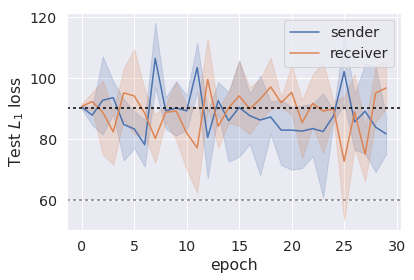

bias 15 run_id b6f00df4be8f25cbe76506fd1453f4d8 score 17.778755416870112 l1 17.778755416870112
config file ../results/cat-deter-l1/cat-deter-bias15_b6f00df4be8f25cbe76506fd1453f4d8/0/config.gin
plotting from ../results/cat-deter-l1/cat-deter-bias15_b6f00df4be8f25cbe76506fd1453f4d8/0/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias15_b6f00df4be8f25cbe76506fd1453f4d8/1/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias15_b6f00df4be8f25cbe76506fd1453f4d8/4/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias15_b6f00df4be8f25cbe76506fd1453f4d8/3/logs.json
plotting from ../results/cat-deter-l1/cat-deter-bias15_b6f00df4be8f25cbe76506fd1453f4d8/2/logs.json


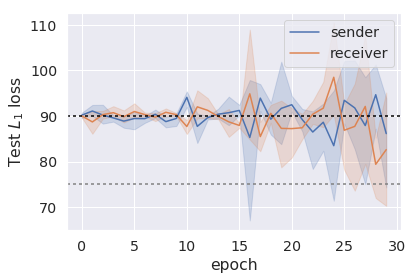

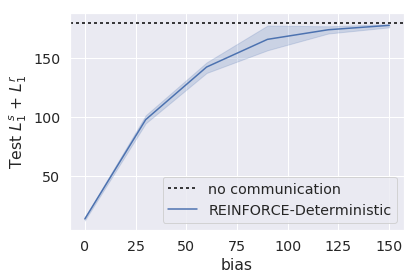

bias 0 run_id f04f33df38cd4ed3e69482dd85907048 score 0.08580408535897648 l1 1.3753189039230338
config file ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/0/config.gin
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/0/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/2/logs.json


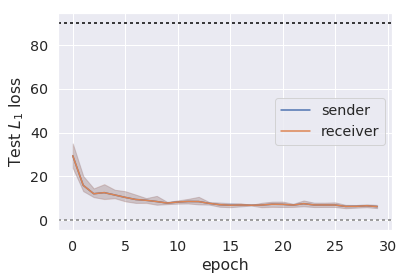

bias 3 run_id b9943073309d9e9fadd5957e148c0c46 score 3.9888681745529175 l1 9.791334295272828
config file ../results/cat-deter/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/0/config.gin
plotting from ../results/cat-deter/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/0/logs.json
plotting from ../results/cat-deter/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/2/logs.json


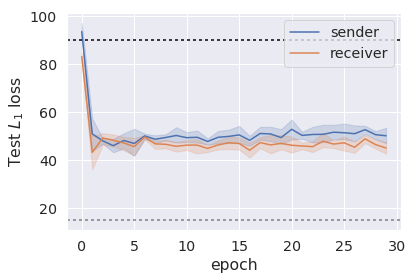

bias 6 run_id 335997298bbccd4ed65136267d4571eb score 8.175776524543762 l1 14.24613522529602
config file ../results/cat-deter/cat-deter-bias6_335997298bbccd4ed65136267d4571eb/0/config.gin
plotting from ../results/cat-deter/cat-deter-bias6_335997298bbccd4ed65136267d4571eb/0/logs.json
plotting from ../results/cat-deter/cat-deter-bias6_335997298bbccd4ed65136267d4571eb/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias6_335997298bbccd4ed65136267d4571eb/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias6_335997298bbccd4ed65136267d4571eb/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias6_335997298bbccd4ed65136267d4571eb/2/logs.json


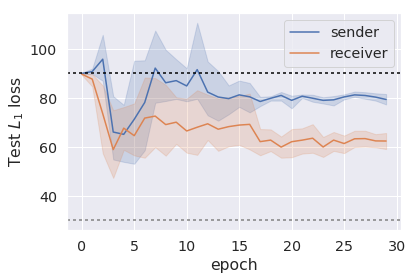

bias 9 run_id 9bf407970f6b0b9eec17d92cbb8f755f score 10.590582780838014 l1 16.59253533363342
config file ../results/cat-deter/cat-deter-bias9_9bf407970f6b0b9eec17d92cbb8f755f/0/config.gin
plotting from ../results/cat-deter/cat-deter-bias9_9bf407970f6b0b9eec17d92cbb8f755f/0/logs.json
plotting from ../results/cat-deter/cat-deter-bias9_9bf407970f6b0b9eec17d92cbb8f755f/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias9_9bf407970f6b0b9eec17d92cbb8f755f/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias9_9bf407970f6b0b9eec17d92cbb8f755f/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias9_9bf407970f6b0b9eec17d92cbb8f755f/2/logs.json


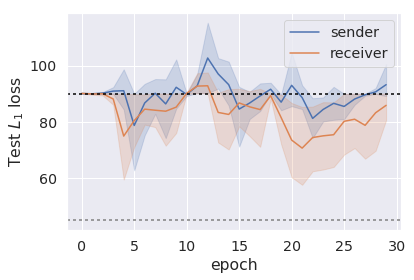

bias 12 run_id 01fd084cc1e8d94744162882ac36e320 score 11.377442073822019 l1 17.407645874023434
config file ../results/cat-deter/cat-deter-bias12_01fd084cc1e8d94744162882ac36e320/0/config.gin
plotting from ../results/cat-deter/cat-deter-bias12_01fd084cc1e8d94744162882ac36e320/0/logs.json
plotting from ../results/cat-deter/cat-deter-bias12_01fd084cc1e8d94744162882ac36e320/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias12_01fd084cc1e8d94744162882ac36e320/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias12_01fd084cc1e8d94744162882ac36e320/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias12_01fd084cc1e8d94744162882ac36e320/2/logs.json


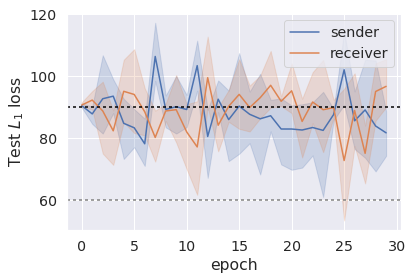

bias 15 run_id 6f452c885c46671fbdd90109aeb53015 score 11.792842328548431 l1 17.813429794311524
config file ../results/cat-deter/cat-deter-bias15_6f452c885c46671fbdd90109aeb53015/0/config.gin
plotting from ../results/cat-deter/cat-deter-bias15_6f452c885c46671fbdd90109aeb53015/0/logs.json
plotting from ../results/cat-deter/cat-deter-bias15_6f452c885c46671fbdd90109aeb53015/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias15_6f452c885c46671fbdd90109aeb53015/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias15_6f452c885c46671fbdd90109aeb53015/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias15_6f452c885c46671fbdd90109aeb53015/2/logs.json


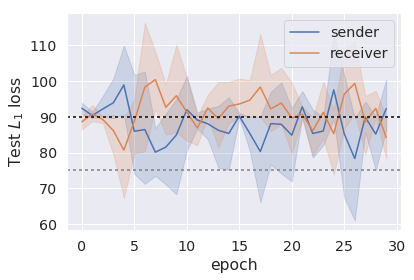

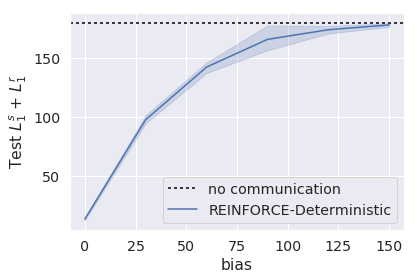

<Figure size 432x288 with 0 Axes>

In [417]:
## REINFORCE - DETERMINISTIC L1
resultspath = Path('../results/cat-deter-l1')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)

#     plt.title(f'LOLA-{i}')
#     plot(logpath)
    plot_hyperparam_results(resultspath, 'REINFORCE-Deterministic', resultspath / 'plots')

## REINFORCE - DETERMINISTIC L2
resultspath = Path('../results/cat-deter')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)

#     plt.title(f'LOLA-{i}')
#     plot(logpath)
    plot_hyperparam_results(resultspath, 'REINFORCE-Deterministic', resultspath / 'plots')

    

bias 0 run_id f04f33df38cd4ed3e69482dd85907048 score 0.08580408535897648 l1 1.3753189039230338
config file ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/0/config.gin
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/0/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/2/logs.json
bias 3 run_id b9943073309d9e9fadd5957e148c0c46 score 3.9888681745529175 l1 9.791334295272828
config file ../results/cat-deter/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/0/config.gin
plotting from ../results/cat-deter/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/0/logs.json
plotting from ../results/cat-deter/cat-deter-b

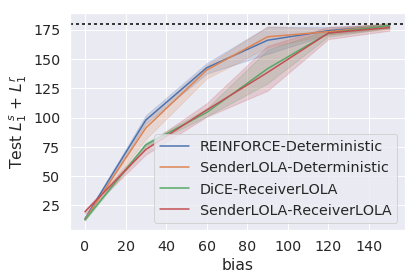

In [418]:
## LOLA 1 GRAPH
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    
    logpath = Path('../results/cat-deter')
    label='REINFORCE-Deterministic'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    logpath = Path('../results/senderlola1-deter')
    label='SenderLOLA-Deterministic'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
    logpath = Path('../results/senderlola0-recverlola1')
    label='DiCE-ReceiverLOLA'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)


    logpath = Path('../results/senderlola1-recverlola1')
    label='SenderLOLA-ReceiverLOLA'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    plt.axhline(torch.tensor(360 / 2), label='no communication', color="black", dashes=(2,2,2,2))

    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.savefig(f'../results/lola1-all.png',  bbox_inches='tight')


bias 0 run_id 1364d13198b3d4eb1264cab01dbf2705 score 2.6603458952903742 l1 1.9628803229331964
config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/0/config.gin
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/0/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/1/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/4/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/3/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/2/logs.json
bias 3 run_id 24bc831a5e440cfbc02da489d2f155e4 score 38.88937200546265 l1 7.273522143363952
config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-

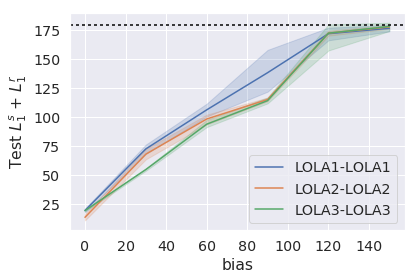

In [419]:
## LOLA 1,2,3 L2 GRAPH
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    
#     logpath = Path('../results/cat-deter')
#     label='REINFORCE-Deterministic'
#     results = pd.read_csv(logpath / 'results.csv')
#     sns.lineplot(data=results, x=results['bias']*10, y=results['l1']*10, label=label)

    logpath = Path('../results/senderlola1-recverlola1')
    label='LOLA1-LOLA1'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
    logpath = Path('../results/senderlola2-recverlola2')
    label='LOLA2-LOLA2'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
    logpath = Path('../results/senderlola3-recverlola3')
    label='LOLA3-LOLA3'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
    plt.axhline(torch.tensor(360 / 2), color="black", dashes=(2,2,2,2))
    plt.legend()

    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.savefig(f'../results/lola123-all.png',  bbox_inches='tight')

bias 0 run_id 5c2c4aab49edb9fb9e61cfb9a2220a5b score 1.2162181532382956 l1 1.2743104827404017
config file ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias0_5c2c4aab49edb9fb9e61cfb9a2220a5b/0/config.gin
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias0_5c2c4aab49edb9fb9e61cfb9a2220a5b/0/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias0_5c2c4aab49edb9fb9e61cfb9a2220a5b/1/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias0_5c2c4aab49edb9fb9e61cfb9a2220a5b/4/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias0_5c2c4aab49edb9fb9e61cfb9a2220a5b/3/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias0_5c2c4aab49edb9fb9e61cfb9a2220a5b/2/logs.json


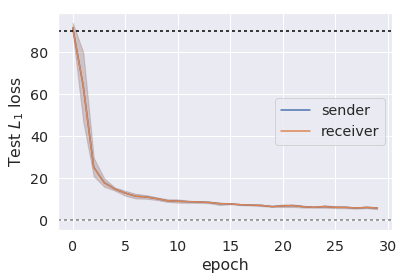

bias 3 run_id 942cd8a3e04b7edc541ea5dffbb05f74 score 45.8254821395874 l1 7.677191071510316
config file ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias3_942cd8a3e04b7edc541ea5dffbb05f74/0/config.gin
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias3_942cd8a3e04b7edc541ea5dffbb05f74/0/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias3_942cd8a3e04b7edc541ea5dffbb05f74/1/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias3_942cd8a3e04b7edc541ea5dffbb05f74/4/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias3_942cd8a3e04b7edc541ea5dffbb05f74/3/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias3_942cd8a3e04b7edc541ea5dffbb05f74/2/logs.json


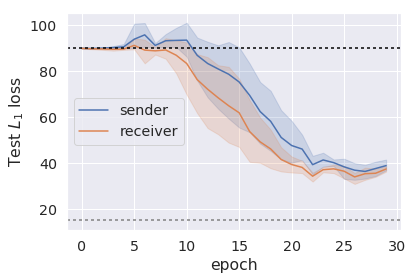

bias 6 run_id 31e13f27718fb464b556f41b83de2b3e score 82.56045627593994 l1 10.435690326690674
config file ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias6_31e13f27718fb464b556f41b83de2b3e/0/config.gin
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias6_31e13f27718fb464b556f41b83de2b3e/0/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias6_31e13f27718fb464b556f41b83de2b3e/1/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias6_31e13f27718fb464b556f41b83de2b3e/4/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias6_31e13f27718fb464b556f41b83de2b3e/3/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias6_31e13f27718fb464b556f41b83de2b3e/2/logs.json


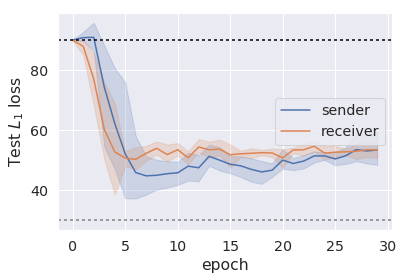

bias 9 run_id b652474dd4a0c7d1c5357d2cdfc177a0 score 146.7813547897339 l1 14.167479429244995
config file ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias9_b652474dd4a0c7d1c5357d2cdfc177a0/0/config.gin
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias9_b652474dd4a0c7d1c5357d2cdfc177a0/0/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias9_b652474dd4a0c7d1c5357d2cdfc177a0/1/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias9_b652474dd4a0c7d1c5357d2cdfc177a0/4/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias9_b652474dd4a0c7d1c5357d2cdfc177a0/3/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias9_b652474dd4a0c7d1c5357d2cdfc177a0/2/logs.json


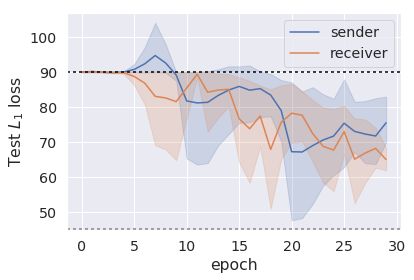

bias 12 run_id 0378eec008a621b553c96330585b1090 score 201.1128600311279 l1 17.19542788505554
config file ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias12_0378eec008a621b553c96330585b1090/0/config.gin
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias12_0378eec008a621b553c96330585b1090/0/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias12_0378eec008a621b553c96330585b1090/1/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias12_0378eec008a621b553c96330585b1090/4/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias12_0378eec008a621b553c96330585b1090/3/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias12_0378eec008a621b553c96330585b1090/2/logs.json


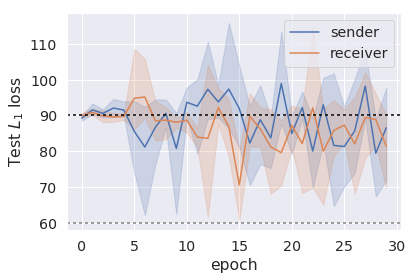

bias 15 run_id c405e967c4e4e63c684381c74e907712 score 212.0104367828369 l1 17.851364488601686
config file ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias15_c405e967c4e4e63c684381c74e907712/0/config.gin
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias15_c405e967c4e4e63c684381c74e907712/0/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias15_c405e967c4e4e63c684381c74e907712/1/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias15_c405e967c4e4e63c684381c74e907712/4/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias15_c405e967c4e4e63c684381c74e907712/3/logs.json
plotting from ../results/senderlola0-recverlola1/senderlola0-recverlola1-bias15_c405e967c4e4e63c684381c74e907712/2/logs.json


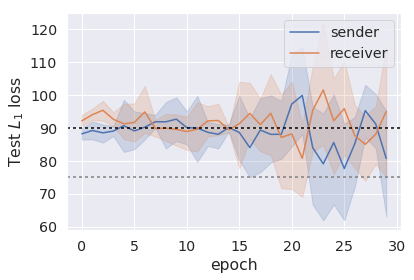

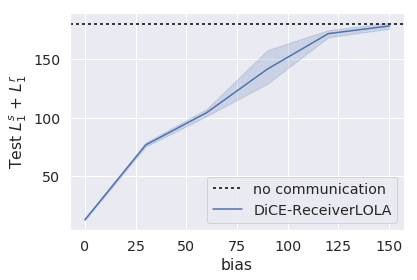

<Figure size 432x288 with 0 Axes>

In [420]:
## DiCE - ReceiverLOLA 1
resultspath = Path('../results/senderlola0-recverlola1')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'DiCE-ReceiverLOLA', resultspath / 'plots')

bias 0 run_id bf9fb1f34ed087ed987f5e58960c00b0 score 1.2594878649711598 l1 1.3153354978561391
config file ../results/senderlola1-deter/senderlola1-deter-bias0_bf9fb1f34ed087ed987f5e58960c00b0/0/config.gin
plotting from ../results/senderlola1-deter/senderlola1-deter-bias0_bf9fb1f34ed087ed987f5e58960c00b0/0/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias0_bf9fb1f34ed087ed987f5e58960c00b0/1/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias0_bf9fb1f34ed087ed987f5e58960c00b0/4/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias0_bf9fb1f34ed087ed987f5e58960c00b0/3/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias0_bf9fb1f34ed087ed987f5e58960c00b0/2/logs.json


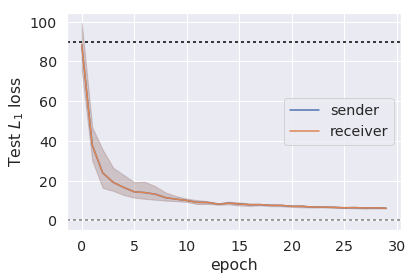

bias 3 run_id 2dfb03c23bf576913c6f682a3984b95f score 64.37353248596193 l1 9.110296010971068
config file ../results/senderlola1-deter/senderlola1-deter-bias3_2dfb03c23bf576913c6f682a3984b95f/0/config.gin
plotting from ../results/senderlola1-deter/senderlola1-deter-bias3_2dfb03c23bf576913c6f682a3984b95f/0/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias3_2dfb03c23bf576913c6f682a3984b95f/1/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias3_2dfb03c23bf576913c6f682a3984b95f/4/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias3_2dfb03c23bf576913c6f682a3984b95f/3/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias3_2dfb03c23bf576913c6f682a3984b95f/2/logs.json


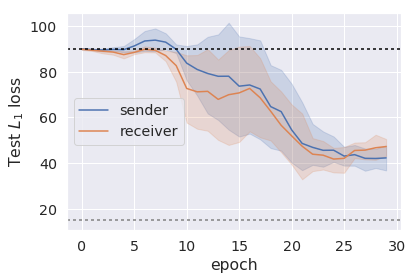

bias 6 run_id 273fa43b42c4e921349b1dffe1433654 score 145.36240837097168 l1 14.052554340362546
config file ../results/senderlola1-deter/senderlola1-deter-bias6_273fa43b42c4e921349b1dffe1433654/0/config.gin
plotting from ../results/senderlola1-deter/senderlola1-deter-bias6_273fa43b42c4e921349b1dffe1433654/0/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias6_273fa43b42c4e921349b1dffe1433654/1/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias6_273fa43b42c4e921349b1dffe1433654/4/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias6_273fa43b42c4e921349b1dffe1433654/3/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias6_273fa43b42c4e921349b1dffe1433654/2/logs.json


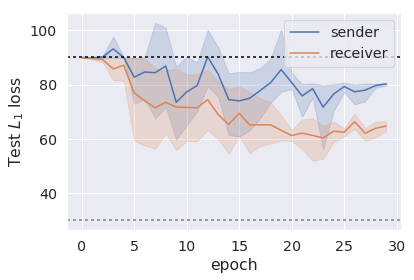

bias 9 run_id 5f4cc90fc62d5849c38b8efec2406be9 score 195.84301319122315 l1 16.8879722070694
config file ../results/senderlola1-deter/senderlola1-deter-bias9_5f4cc90fc62d5849c38b8efec2406be9/0/config.gin
plotting from ../results/senderlola1-deter/senderlola1-deter-bias9_5f4cc90fc62d5849c38b8efec2406be9/0/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias9_5f4cc90fc62d5849c38b8efec2406be9/1/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias9_5f4cc90fc62d5849c38b8efec2406be9/4/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias9_5f4cc90fc62d5849c38b8efec2406be9/3/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias9_5f4cc90fc62d5849c38b8efec2406be9/2/logs.json


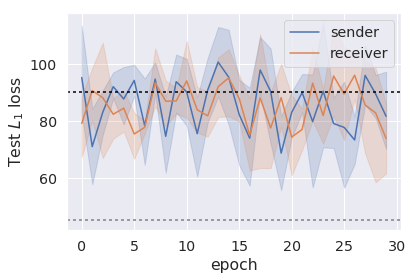

bias 12 run_id 0f6c0de8730c881521c558bb3cb6375b score 202.88329349517826 l1 17.32560476303101
config file ../results/senderlola1-deter/senderlola1-deter-bias12_0f6c0de8730c881521c558bb3cb6375b/0/config.gin
plotting from ../results/senderlola1-deter/senderlola1-deter-bias12_0f6c0de8730c881521c558bb3cb6375b/0/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias12_0f6c0de8730c881521c558bb3cb6375b/1/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias12_0f6c0de8730c881521c558bb3cb6375b/4/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias12_0f6c0de8730c881521c558bb3cb6375b/3/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias12_0f6c0de8730c881521c558bb3cb6375b/2/logs.json


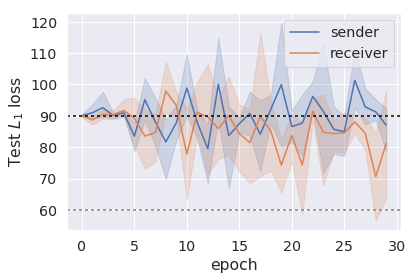

bias 15 run_id e4421e1e83cef745d02cfb7de458dd1c score 211.99727767944336 l1 17.836768751144408
config file ../results/senderlola1-deter/senderlola1-deter-bias15_e4421e1e83cef745d02cfb7de458dd1c/0/config.gin
plotting from ../results/senderlola1-deter/senderlola1-deter-bias15_e4421e1e83cef745d02cfb7de458dd1c/0/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias15_e4421e1e83cef745d02cfb7de458dd1c/1/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias15_e4421e1e83cef745d02cfb7de458dd1c/4/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias15_e4421e1e83cef745d02cfb7de458dd1c/3/logs.json
plotting from ../results/senderlola1-deter/senderlola1-deter-bias15_e4421e1e83cef745d02cfb7de458dd1c/2/logs.json


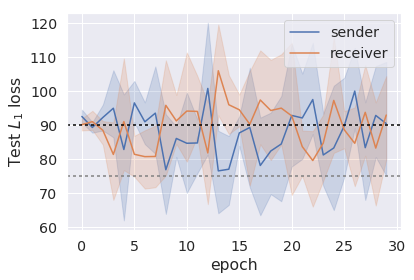

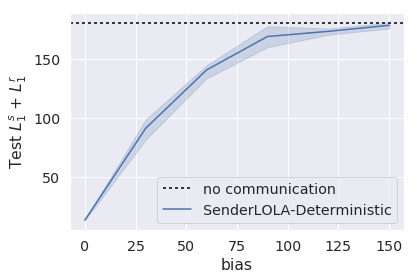

<Figure size 432x288 with 0 Axes>

In [421]:
## SenderLOLA 1 - Deter
resultspath = Path('../results/senderlola1-deter')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'SenderLOLA-Deterministic', resultspath / 'plots')

bias 0 run_id 1364d13198b3d4eb1264cab01dbf2705 score 2.6603458952903742 l1 1.9628803229331964
config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/0/config.gin
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/0/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/1/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/4/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/3/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias0_1364d13198b3d4eb1264cab01dbf2705/2/logs.json


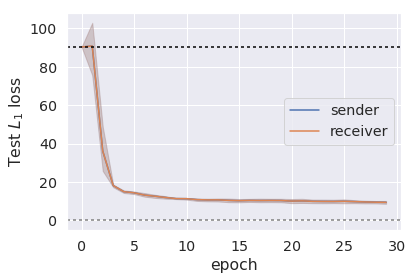

bias 3 run_id 24bc831a5e440cfbc02da489d2f155e4 score 38.88937200546265 l1 7.273522143363952
config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias3_24bc831a5e440cfbc02da489d2f155e4/0/config.gin
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias3_24bc831a5e440cfbc02da489d2f155e4/0/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias3_24bc831a5e440cfbc02da489d2f155e4/1/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias3_24bc831a5e440cfbc02da489d2f155e4/4/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias3_24bc831a5e440cfbc02da489d2f155e4/3/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias3_24bc831a5e440cfbc02da489d2f155e4/2/logs.json


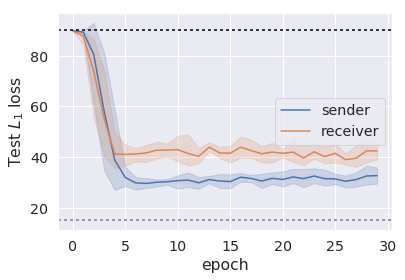

bias 6 run_id 62bc6ada8541543e0462779ac522e2c6 score 85.80220165252685 l1 10.641829681396484
config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias6_62bc6ada8541543e0462779ac522e2c6/0/config.gin
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias6_62bc6ada8541543e0462779ac522e2c6/0/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias6_62bc6ada8541543e0462779ac522e2c6/1/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias6_62bc6ada8541543e0462779ac522e2c6/4/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias6_62bc6ada8541543e0462779ac522e2c6/3/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias6_62bc6ada8541543e0462779ac522e2c6/2/logs.json


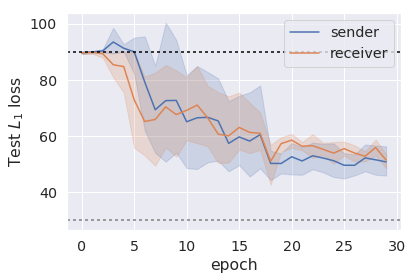

bias 9 run_id fd49b50c961a65ef9e99266dc143d904 score 141.00271503448488 l1 13.8446870803833
config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904/0/config.gin
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904/0/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904/1/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904/4/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904/3/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904/2/logs.json


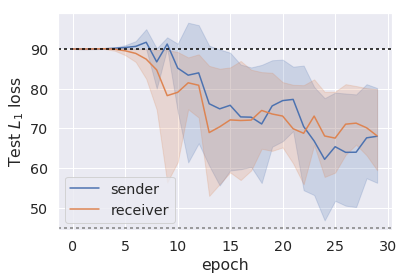

bias 12 run_id 1f2eda832f7890ed995f9e96b0037178 score 200.9776541519165 l1 17.21061053276062
config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias12_1f2eda832f7890ed995f9e96b0037178/0/config.gin
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias12_1f2eda832f7890ed995f9e96b0037178/0/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias12_1f2eda832f7890ed995f9e96b0037178/1/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias12_1f2eda832f7890ed995f9e96b0037178/4/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias12_1f2eda832f7890ed995f9e96b0037178/3/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias12_1f2eda832f7890ed995f9e96b0037178/2/logs.json


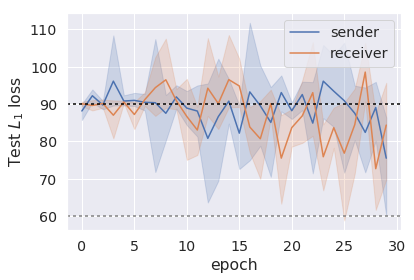

bias 15 run_id 897d38bec3634b1a757527c94a466995 score 211.1358987426758 l1 17.675190868377687
config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias15_897d38bec3634b1a757527c94a466995/0/config.gin
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias15_897d38bec3634b1a757527c94a466995/0/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias15_897d38bec3634b1a757527c94a466995/1/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias15_897d38bec3634b1a757527c94a466995/4/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias15_897d38bec3634b1a757527c94a466995/3/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias15_897d38bec3634b1a757527c94a466995/2/logs.json


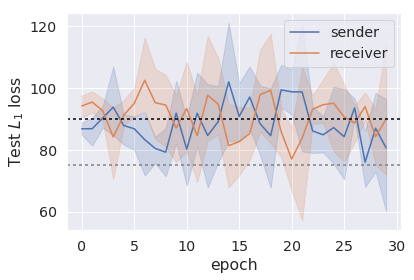

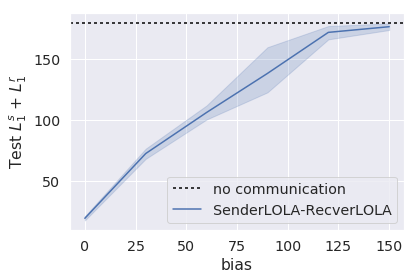

<Figure size 432x288 with 0 Axes>

In [422]:
## SenderLOLA 1 - ReceiverLOLA 1
resultspath = Path('../results/senderlola1-recverlola1')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'SenderLOLA-RecverLOLA', resultspath / 'plots')

bias 0 run_id e8e90a3f01d9906eadf37809d9ff3b0b score 1.5446393859386438 l1 1.375735347270965
config file ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias0_e8e90a3f01d9906eadf37809d9ff3b0b/0/config.gin
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias0_e8e90a3f01d9906eadf37809d9ff3b0b/0/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias0_e8e90a3f01d9906eadf37809d9ff3b0b/1/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias0_e8e90a3f01d9906eadf37809d9ff3b0b/4/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias0_e8e90a3f01d9906eadf37809d9ff3b0b/3/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias0_e8e90a3f01d9906eadf37809d9ff3b0b/2/logs.json


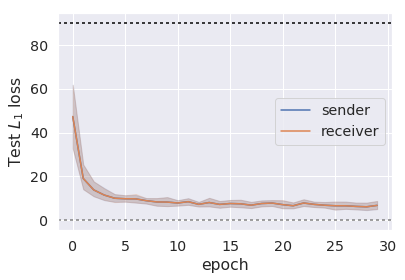

bias 3 run_id 6e02a3be5dd60d9f48ca1315f689d3b5 score 35.187170753479 l1 6.8214720582962025
config file ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias3_6e02a3be5dd60d9f48ca1315f689d3b5/0/config.gin
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias3_6e02a3be5dd60d9f48ca1315f689d3b5/0/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias3_6e02a3be5dd60d9f48ca1315f689d3b5/1/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias3_6e02a3be5dd60d9f48ca1315f689d3b5/4/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias3_6e02a3be5dd60d9f48ca1315f689d3b5/3/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias3_6e02a3be5dd60d9f48ca1315f689d3b5/2/logs.json


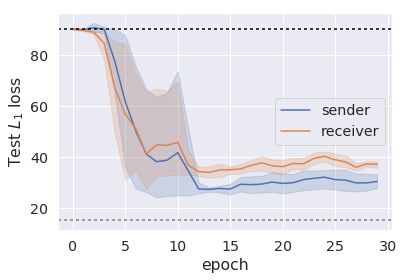

bias 6 run_id 5008af90086420ddc0c4320a18d64804 score 74.17520488739014 l1 9.853082146644592
config file ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias6_5008af90086420ddc0c4320a18d64804/0/config.gin
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias6_5008af90086420ddc0c4320a18d64804/0/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias6_5008af90086420ddc0c4320a18d64804/1/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias6_5008af90086420ddc0c4320a18d64804/4/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias6_5008af90086420ddc0c4320a18d64804/3/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias6_5008af90086420ddc0c4320a18d64804/2/logs.json


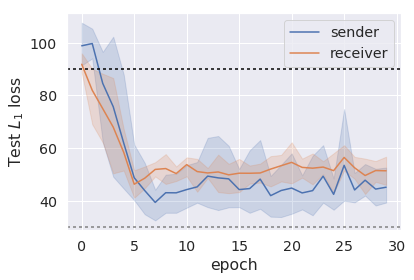

bias 9 run_id cc1066c26ddceea8e316d188223fc87c score 99.81696399688721 l1 11.53426443576813
config file ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c/0/config.gin
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c/0/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c/1/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c/4/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c/3/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c/2/logs.json


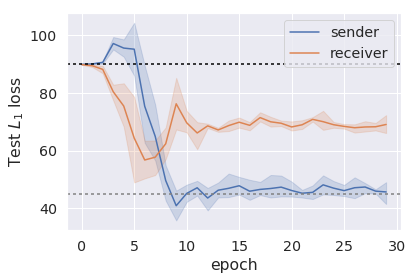

bias 12 run_id 385b40c7efda2b05aef3d9a5f19fdcba score 202.8192750930786 l1 17.256701354980468
config file ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias12_385b40c7efda2b05aef3d9a5f19fdcba/0/config.gin
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias12_385b40c7efda2b05aef3d9a5f19fdcba/0/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias12_385b40c7efda2b05aef3d9a5f19fdcba/1/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias12_385b40c7efda2b05aef3d9a5f19fdcba/4/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias12_385b40c7efda2b05aef3d9a5f19fdcba/3/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias12_385b40c7efda2b05aef3d9a5f19fdcba/2/logs.json


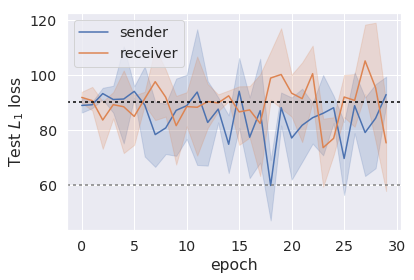

bias 15 run_id 36f58c94b5876287fa07acc9968f37b0 score 211.9017590332031 l1 17.791953382492064
config file ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias15_36f58c94b5876287fa07acc9968f37b0/0/config.gin
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias15_36f58c94b5876287fa07acc9968f37b0/0/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias15_36f58c94b5876287fa07acc9968f37b0/1/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias15_36f58c94b5876287fa07acc9968f37b0/4/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias15_36f58c94b5876287fa07acc9968f37b0/3/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias15_36f58c94b5876287fa07acc9968f37b0/2/logs.json


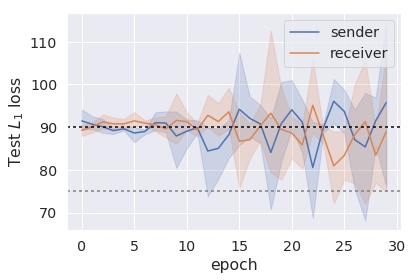

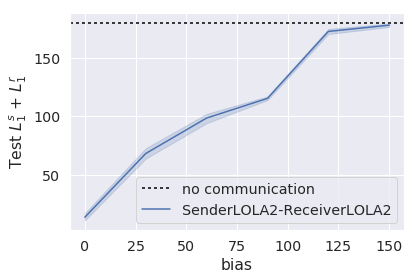

<Figure size 432x288 with 0 Axes>

In [423]:
## SenderLOLA 2 - ReceiverLOLA 2
resultspath = Path('../results/senderlola2-recverlola2')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'SenderLOLA2-ReceiverLOLA2', resultspath / 'plots')

bias 0 run_id facb505b43ff82720e7e69bc88c1e8f3 score 2.8369902706146237 l1 1.952727077007293
config file ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias0_facb505b43ff82720e7e69bc88c1e8f3/0/config.gin
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias0_facb505b43ff82720e7e69bc88c1e8f3/0/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias0_facb505b43ff82720e7e69bc88c1e8f3/1/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias0_facb505b43ff82720e7e69bc88c1e8f3/4/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias0_facb505b43ff82720e7e69bc88c1e8f3/3/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias0_facb505b43ff82720e7e69bc88c1e8f3/2/logs.json


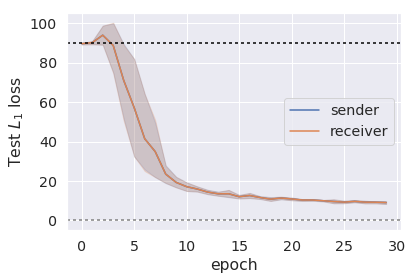

bias 3 run_id ca174b34dcdaa0535fd7e2a9e7e46eec score 23.014094171524054 l1 5.4973346018791185
config file ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias3_ca174b34dcdaa0535fd7e2a9e7e46eec/0/config.gin
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias3_ca174b34dcdaa0535fd7e2a9e7e46eec/0/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias3_ca174b34dcdaa0535fd7e2a9e7e46eec/1/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias3_ca174b34dcdaa0535fd7e2a9e7e46eec/4/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias3_ca174b34dcdaa0535fd7e2a9e7e46eec/3/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias3_ca174b34dcdaa0535fd7e2a9e7e46eec/2/logs.json


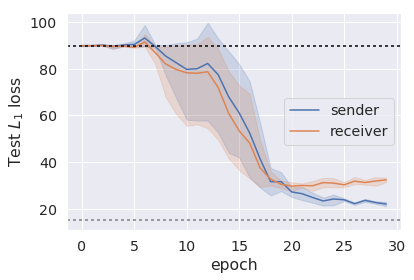

bias 6 run_id 36428ca31182a4ccdf8f85d7beddde40 score 65.21786165237428 l1 9.405745453834534
config file ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias6_36428ca31182a4ccdf8f85d7beddde40/0/config.gin
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias6_36428ca31182a4ccdf8f85d7beddde40/0/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias6_36428ca31182a4ccdf8f85d7beddde40/1/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias6_36428ca31182a4ccdf8f85d7beddde40/4/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias6_36428ca31182a4ccdf8f85d7beddde40/3/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias6_36428ca31182a4ccdf8f85d7beddde40/2/logs.json


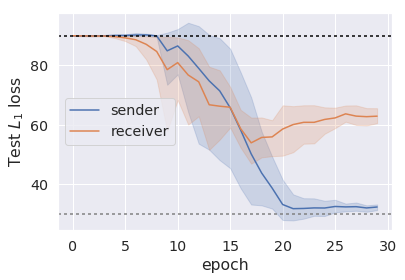

bias 9 run_id 231e396545671420018c27cf6d41c608 score 98.43096935272214 l1 11.435028576850893
config file ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias9_231e396545671420018c27cf6d41c608/0/config.gin
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias9_231e396545671420018c27cf6d41c608/0/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias9_231e396545671420018c27cf6d41c608/1/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias9_231e396545671420018c27cf6d41c608/4/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias9_231e396545671420018c27cf6d41c608/3/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias9_231e396545671420018c27cf6d41c608/2/logs.json


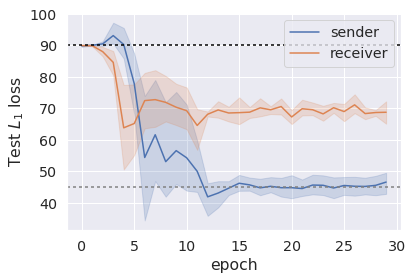

bias 12 run_id c0261ff0b05928f018e93af54be57c34 score 202.32917449951168 l1 17.253463830947876
config file ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias12_c0261ff0b05928f018e93af54be57c34/0/config.gin
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias12_c0261ff0b05928f018e93af54be57c34/0/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias12_c0261ff0b05928f018e93af54be57c34/1/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias12_c0261ff0b05928f018e93af54be57c34/4/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias12_c0261ff0b05928f018e93af54be57c34/3/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias12_c0261ff0b05928f018e93af54be57c34/2/logs.json


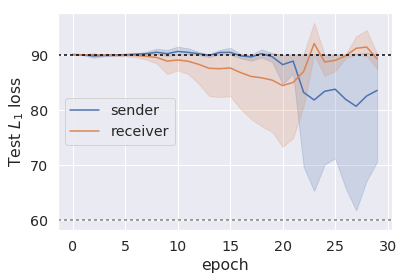

bias 15 run_id d93dbfd44a3fc2b2e6acb6ded006db1d score 212.47999366760254 l1 17.834770231246946
config file ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias15_d93dbfd44a3fc2b2e6acb6ded006db1d/0/config.gin
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias15_d93dbfd44a3fc2b2e6acb6ded006db1d/0/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias15_d93dbfd44a3fc2b2e6acb6ded006db1d/1/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias15_d93dbfd44a3fc2b2e6acb6ded006db1d/4/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias15_d93dbfd44a3fc2b2e6acb6ded006db1d/3/logs.json
plotting from ../results/senderlola3-recverlola3/senderlola3-recverlola3-bias15_d93dbfd44a3fc2b2e6acb6ded006db1d/2/logs.json


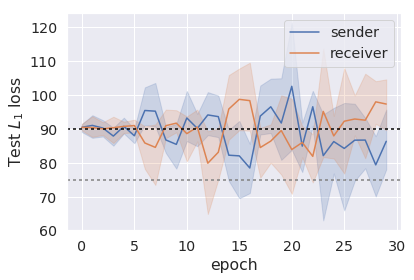

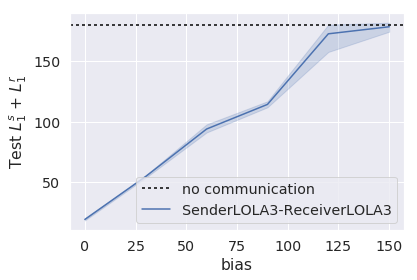

<Figure size 432x288 with 0 Axes>

In [424]:
## SenderLOLA 3 - ReceiverLOLA 3
resultspath = Path('../results/senderlola3-recverlola3')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'SenderLOLA3-ReceiverLOLA3', resultspath / 'plots')

bias 0 run_id 59fa44ba00600a5a27a1120e7c677cfa score 1.2545362436771383 l1 1.2893198978900904
config file ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias0_59fa44ba00600a5a27a1120e7c677cfa/0/config.gin
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias0_59fa44ba00600a5a27a1120e7c677cfa/0/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias0_59fa44ba00600a5a27a1120e7c677cfa/1/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias0_59fa44ba00600a5a27a1120e7c677cfa/4/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias0_59fa44ba00600a5a27a1120e7c677cfa/3/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias0_59fa44ba00600a5a27a1120e7c677cfa/2/logs.json


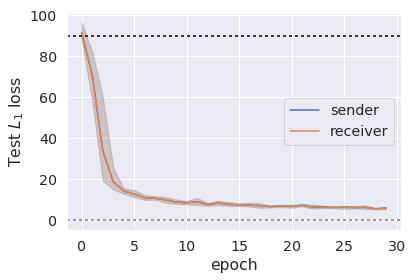

bias 3 run_id 897ea5ca7592822c9461cdf347071860 score 34.42378217697144 l1 6.8059291696548465
config file ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias3_897ea5ca7592822c9461cdf347071860/0/config.gin
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias3_897ea5ca7592822c9461cdf347071860/0/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias3_897ea5ca7592822c9461cdf347071860/1/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias3_897ea5ca7592822c9461cdf347071860/4/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias3_897ea5ca7592822c9461cdf347071860/3/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias3_897ea5ca7592822c9461cdf347071860/2/logs.json


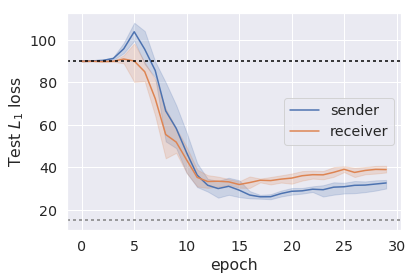

bias 6 run_id d3c1bd93ae80aea667e3221875439d26 score 79.4091621017456 l1 10.253977999687194
config file ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias6_d3c1bd93ae80aea667e3221875439d26/0/config.gin
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias6_d3c1bd93ae80aea667e3221875439d26/0/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias6_d3c1bd93ae80aea667e3221875439d26/1/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias6_d3c1bd93ae80aea667e3221875439d26/4/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias6_d3c1bd93ae80aea667e3221875439d26/3/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias6_d3c1bd93ae80aea667e3221875439d26/2/logs.json


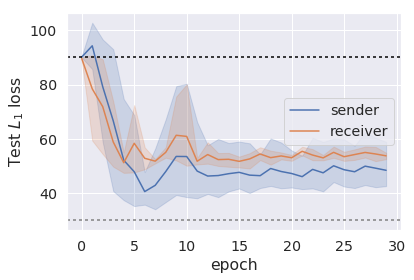

bias 9 run_id 769e1b0b75d1f08184f15e7a5fec09f6 score 124.93321968078614 l1 12.925289192199706
config file ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias9_769e1b0b75d1f08184f15e7a5fec09f6/0/config.gin
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias9_769e1b0b75d1f08184f15e7a5fec09f6/0/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias9_769e1b0b75d1f08184f15e7a5fec09f6/1/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias9_769e1b0b75d1f08184f15e7a5fec09f6/4/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias9_769e1b0b75d1f08184f15e7a5fec09f6/3/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias9_769e1b0b75d1f08184f15e7a5fec09f6/2/logs.json


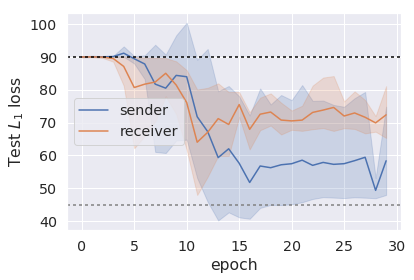

bias 12 run_id 5b5b2872fb12e7ffbed3208dec4f633a score 201.4669966506958 l1 17.152788467407227
config file ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias12_5b5b2872fb12e7ffbed3208dec4f633a/0/config.gin
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias12_5b5b2872fb12e7ffbed3208dec4f633a/0/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias12_5b5b2872fb12e7ffbed3208dec4f633a/1/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias12_5b5b2872fb12e7ffbed3208dec4f633a/4/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias12_5b5b2872fb12e7ffbed3208dec4f633a/3/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias12_5b5b2872fb12e7ffbed3208dec4f633a/2/logs.json


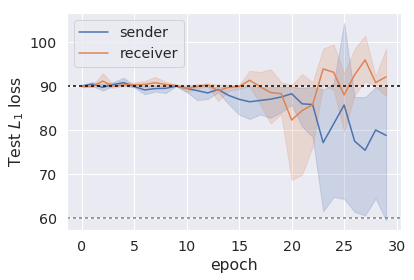

bias 15 run_id e2a29b10f1a188c31f9313caa4b78e12 score 209.27000427246085 l1 17.694610414505007
config file ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias15_e2a29b10f1a188c31f9313caa4b78e12/0/config.gin
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias15_e2a29b10f1a188c31f9313caa4b78e12/0/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias15_e2a29b10f1a188c31f9313caa4b78e12/1/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias15_e2a29b10f1a188c31f9313caa4b78e12/4/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias15_e2a29b10f1a188c31f9313caa4b78e12/3/logs.json
plotting from ../results/senderlola4-recverlola4/senderlola4-recverlola4-bias15_e2a29b10f1a188c31f9313caa4b78e12/2/logs.json


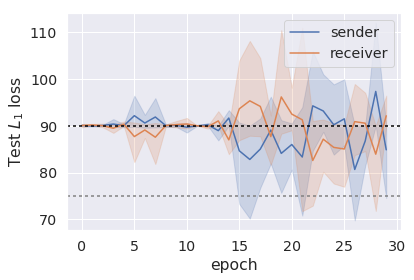

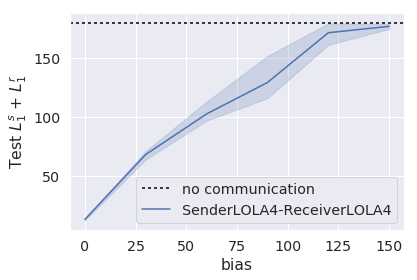

<Figure size 432x288 with 0 Axes>

In [425]:
## SenderLOLA 4 - ReceiverLOLA 4
resultspath = Path('../results/senderlola4-recverlola4')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'SenderLOLA4-ReceiverLOLA4', resultspath / 'plots')

config file ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904/0/config.gin
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904/0/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904/1/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904/4/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904/3/logs.json
plotting from ../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904/2/logs.json


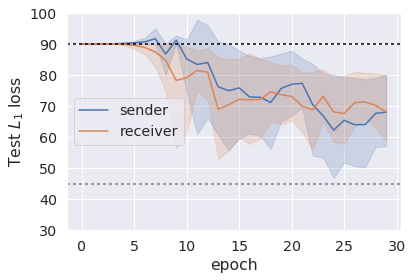

config file ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c/0/config.gin
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c/0/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c/1/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c/4/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c/3/logs.json
plotting from ../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c/2/logs.json


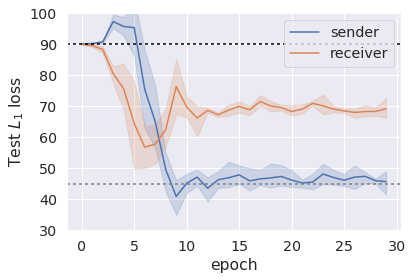

<Figure size 432x288 with 0 Axes>

In [426]:
## Rescaled bias 9 both LOLA-1 vs LOLA-2
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    resultspath = Path('../results/senderlola1-recverlola1/senderlola1-recverlola1-bias9_fd49b50c961a65ef9e99266dc143d904')
    plt.ylim(30,100)
    plot(resultspath, resultspath.parent / 'plots', 'senderlola1-recverlola1-bias9-rescaled')
    
    resultspath = Path('../results/senderlola2-recverlola2/senderlola2-recverlola2-bias9_cc1066c26ddceea8e316d188223fc87c')
    plt.ylim(30,100)
    plot(resultspath, resultspath.parent / 'plots', 'senderlola2-recverlola2-bias9-rescaled')

bias 0 run_id f04f33df38cd4ed3e69482dd85907048 score 0.08580408535897648 l1 1.3753189039230338
config file ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/0/config.gin
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/0/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/1/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/4/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/3/logs.json
plotting from ../results/cat-deter/cat-deter-bias0_f04f33df38cd4ed3e69482dd85907048/2/logs.json
bias 3 run_id b9943073309d9e9fadd5957e148c0c46 score 3.9888681745529175 l1 9.791334295272828
config file ../results/cat-deter/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/0/config.gin
plotting from ../results/cat-deter/cat-deter-bias3_b9943073309d9e9fadd5957e148c0c46/0/logs.json
plotting from ../results/cat-deter/cat-deter-b

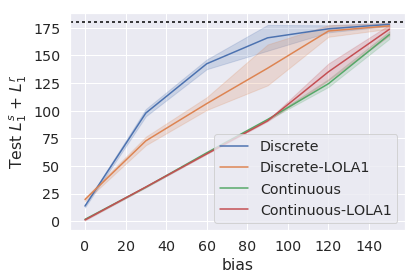

In [427]:
## Continuous GRAPH
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    
    logpath = Path('../results/cat-deter')
    label='Discrete'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)
    
    logpath = Path('../results/senderlola1-recverlola1')
    label='Discrete-LOLA1'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)
    
    
    logpath = Path('../results/gauss-deter')
    label='Continuous'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
    logpath = Path('../results/gausslola1-recverlola1')
    label='Continuous-LOLA1'
    plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
#     logpath = Path('../results/noise-deter')
#     label='Grounded'
#     plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)

    
#     logpath = Path('../results/noiselola1-recverlola1')
#     label='Grounded-LOLA1'
#     plot_hyperparam_results(logpath, label, logpath / 'plots', show=False)


    plt.axhline(torch.tensor(360 / 2), color="black", dashes=(2,2,2,2))
    
#     plt.legend(loc='lower right', n_cols=2)
    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.savefig(f'../results/discrete-v-continuous.png',  bbox_inches='tight')

bias 0 run_id ca624030e0ca4263def31ae9db87babe score 0.02974919405765728 l1 0.1714126067608584
config file ../results/gauss-deter/gauss-deter-bias0_ca624030e0ca4263def31ae9db87babe/0/config.gin
plotting from ../results/gauss-deter/gauss-deter-bias0_ca624030e0ca4263def31ae9db87babe/0/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias0_ca624030e0ca4263def31ae9db87babe/1/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias0_ca624030e0ca4263def31ae9db87babe/4/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias0_ca624030e0ca4263def31ae9db87babe/3/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias0_ca624030e0ca4263def31ae9db87babe/2/logs.json


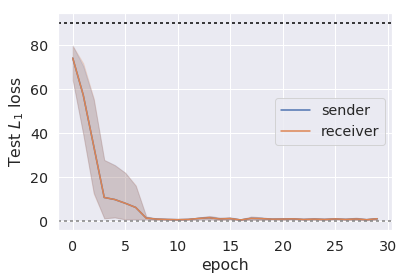

bias 3 run_id f2cfec0e2a14823a54ffd459e12914ae score 8.861319595749958 l1 3.084814655482768
config file ../results/gauss-deter/gauss-deter-bias3_f2cfec0e2a14823a54ffd459e12914ae/0/config.gin
plotting from ../results/gauss-deter/gauss-deter-bias3_f2cfec0e2a14823a54ffd459e12914ae/0/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias3_f2cfec0e2a14823a54ffd459e12914ae/1/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias3_f2cfec0e2a14823a54ffd459e12914ae/4/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias3_f2cfec0e2a14823a54ffd459e12914ae/3/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias3_f2cfec0e2a14823a54ffd459e12914ae/2/logs.json


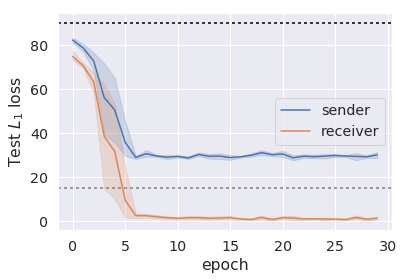

bias 6 run_id 0396388826c5fc62dbf9fb14e3567019 score 35.561255183052275 l1 6.193126335740089
config file ../results/gauss-deter/gauss-deter-bias6_0396388826c5fc62dbf9fb14e3567019/0/config.gin
plotting from ../results/gauss-deter/gauss-deter-bias6_0396388826c5fc62dbf9fb14e3567019/0/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias6_0396388826c5fc62dbf9fb14e3567019/1/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias6_0396388826c5fc62dbf9fb14e3567019/4/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias6_0396388826c5fc62dbf9fb14e3567019/3/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias6_0396388826c5fc62dbf9fb14e3567019/2/logs.json


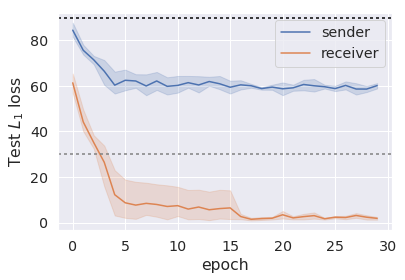

bias 9 run_id 7a409964deff56fee42474623c7cdbb1 score 4.527333377105242 l1 9.205492785051463
config file ../results/gauss-deter/gauss-deter-bias9_7a409964deff56fee42474623c7cdbb1/0/config.gin
plotting from ../results/gauss-deter/gauss-deter-bias9_7a409964deff56fee42474623c7cdbb1/0/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias9_7a409964deff56fee42474623c7cdbb1/1/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias9_7a409964deff56fee42474623c7cdbb1/4/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias9_7a409964deff56fee42474623c7cdbb1/3/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias9_7a409964deff56fee42474623c7cdbb1/2/logs.json


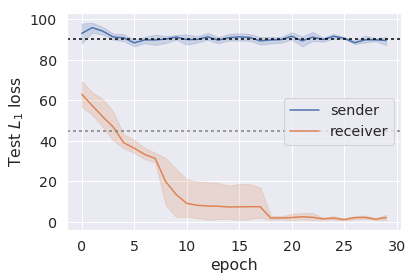

bias 12 run_id bd10f1b4ff1bd82c1132ea63ac4837b9 score 148.05431778310796 l1 12.44450359389186
config file ../results/gauss-deter/gauss-deter-bias12_bd10f1b4ff1bd82c1132ea63ac4837b9/0/config.gin
plotting from ../results/gauss-deter/gauss-deter-bias12_bd10f1b4ff1bd82c1132ea63ac4837b9/0/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias12_bd10f1b4ff1bd82c1132ea63ac4837b9/1/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias12_bd10f1b4ff1bd82c1132ea63ac4837b9/4/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias12_bd10f1b4ff1bd82c1132ea63ac4837b9/3/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias12_bd10f1b4ff1bd82c1132ea63ac4837b9/2/logs.json


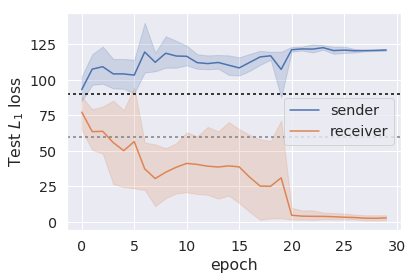

bias 15 run_id 910aca4f21608b1ed25c5eaa0cc84848 score 203.3460710144043 l1 16.882588453292847
config file ../results/gauss-deter/gauss-deter-bias15_910aca4f21608b1ed25c5eaa0cc84848/0/config.gin
plotting from ../results/gauss-deter/gauss-deter-bias15_910aca4f21608b1ed25c5eaa0cc84848/0/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias15_910aca4f21608b1ed25c5eaa0cc84848/1/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias15_910aca4f21608b1ed25c5eaa0cc84848/4/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias15_910aca4f21608b1ed25c5eaa0cc84848/3/logs.json
plotting from ../results/gauss-deter/gauss-deter-bias15_910aca4f21608b1ed25c5eaa0cc84848/2/logs.json


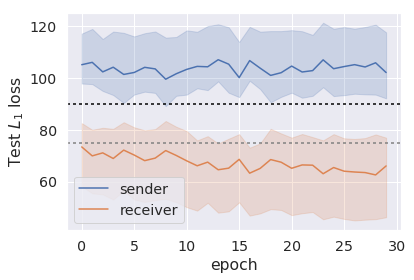

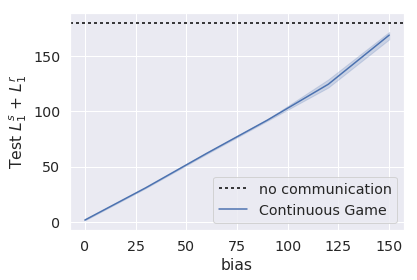

<Figure size 432x288 with 0 Axes>

In [428]:
## Gauss - Deter
resultspath = Path('../results/gauss-deter')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'Continuous Game', resultspath / 'plots')

bias 0 run_id 08b908aa12f1cfee2755f63a9f3642d1 score 0.023724289136006445 l1 0.11943168587982556
config file ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias0_08b908aa12f1cfee2755f63a9f3642d1/0/config.gin
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias0_08b908aa12f1cfee2755f63a9f3642d1/0/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias0_08b908aa12f1cfee2755f63a9f3642d1/1/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias0_08b908aa12f1cfee2755f63a9f3642d1/4/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias0_08b908aa12f1cfee2755f63a9f3642d1/3/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias0_08b908aa12f1cfee2755f63a9f3642d1/2/logs.json


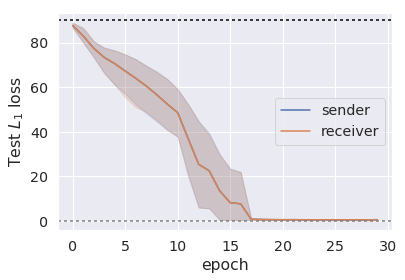

bias 3 run_id a39c2565ba81cedccddcdae737f74bc3 score 8.941015208372846 l1 3.0989989037066694
config file ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias3_a39c2565ba81cedccddcdae737f74bc3/0/config.gin
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias3_a39c2565ba81cedccddcdae737f74bc3/0/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias3_a39c2565ba81cedccddcdae737f74bc3/1/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias3_a39c2565ba81cedccddcdae737f74bc3/4/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias3_a39c2565ba81cedccddcdae737f74bc3/3/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias3_a39c2565ba81cedccddcdae737f74bc3/2/logs.json


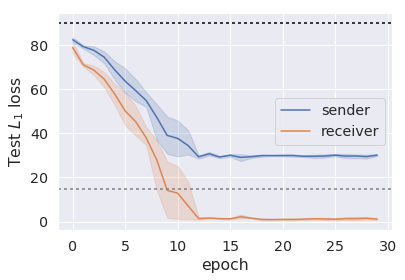

bias 6 run_id f8f3b2bea951b5513a9bd1c300dc532b score 35.94001171234529 l1 6.097282114215195
config file ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias6_f8f3b2bea951b5513a9bd1c300dc532b/0/config.gin
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias6_f8f3b2bea951b5513a9bd1c300dc532b/0/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias6_f8f3b2bea951b5513a9bd1c300dc532b/1/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias6_f8f3b2bea951b5513a9bd1c300dc532b/4/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias6_f8f3b2bea951b5513a9bd1c300dc532b/3/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias6_f8f3b2bea951b5513a9bd1c300dc532b/2/logs.json


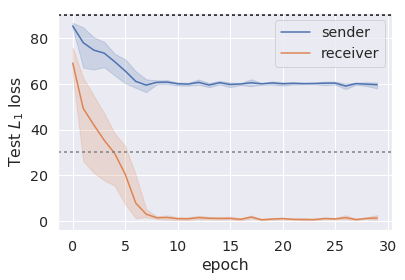

bias 9 run_id 29e46b17ed3d2774395a155418412a4c score 79.36047486394179 l1 9.082493419274687
config file ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias9_29e46b17ed3d2774395a155418412a4c/0/config.gin
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias9_29e46b17ed3d2774395a155418412a4c/0/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias9_29e46b17ed3d2774395a155418412a4c/1/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias9_29e46b17ed3d2774395a155418412a4c/4/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias9_29e46b17ed3d2774395a155418412a4c/3/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias9_29e46b17ed3d2774395a155418412a4c/2/logs.json


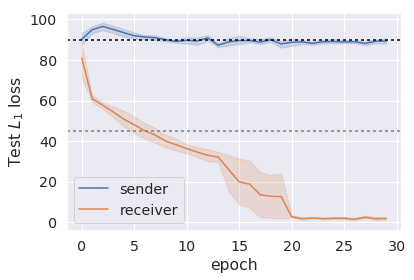

bias 12 run_id 1352d247ac1c3dfebe3928162a3fa621 score 159.93537233908663 l1 13.518980233669284
config file ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias12_1352d247ac1c3dfebe3928162a3fa621/0/config.gin
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias12_1352d247ac1c3dfebe3928162a3fa621/0/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias12_1352d247ac1c3dfebe3928162a3fa621/1/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias12_1352d247ac1c3dfebe3928162a3fa621/4/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias12_1352d247ac1c3dfebe3928162a3fa621/3/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias12_1352d247ac1c3dfebe3928162a3fa621/2/logs.json


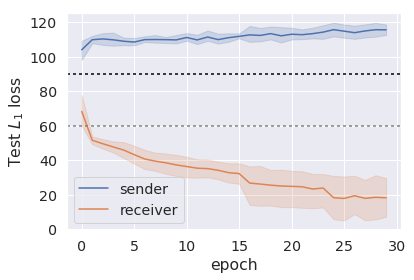

bias 15 run_id c998c8a2909d8559cbf176c0363b9ee8 score 211.85007728576664 l1 17.364742593765264
config file ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias15_c998c8a2909d8559cbf176c0363b9ee8/0/config.gin
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias15_c998c8a2909d8559cbf176c0363b9ee8/0/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias15_c998c8a2909d8559cbf176c0363b9ee8/1/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias15_c998c8a2909d8559cbf176c0363b9ee8/4/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias15_c998c8a2909d8559cbf176c0363b9ee8/3/logs.json
plotting from ../results/gausslola1-recverlola1/gausslola1-recverlola1-bias15_c998c8a2909d8559cbf176c0363b9ee8/2/logs.json


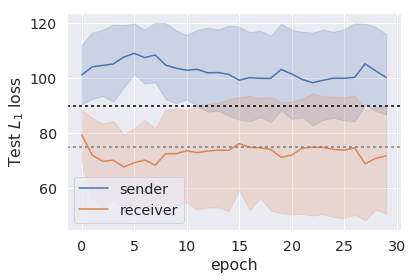

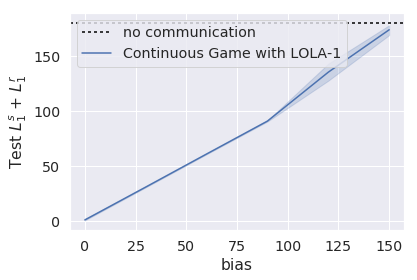

<Figure size 432x288 with 0 Axes>

In [429]:
## GaussLOLA1 - RecverLOLA1 -
resultspath = Path('../results/gausslola1-recverlola1')
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, 'Continuous Game with LOLA-1', resultspath / 'plots')

In [430]:
logdir = '../results/cat-deter-grounded/cat-deter-grounded-bias0_44dd5b063439037131e5651c432885ab'
savepath = None
show = False
logpath = Path(logdir)    

config_file = next(logpath.glob('**/*.gin'))
print(f'config file {config_file}')
gin.parse_config_file(config_file, skip_unknown=True)

bias = gin.config.query_parameter('Game.bias')
num_points = gin.config.query_parameter('Game.num_points')
test_loss = CircleL1(num_points)

run_logs = []
for path in logpath.glob('**/*.json'):
    print(f'plotting from {path}')
    with open(path, 'r') as logfile:
        run_logs.append(pd.read_json(logfile))

logs = pd.concat(run_logs, ignore_index=True)
sender = pd.DataFrame(logs['sender'].to_list()).join(logs['epoch'])
recver = pd.DataFrame(logs['recver'].to_list()).join(logs['epoch'])

if show:
    metric = "test_l1_error" if "test_l1_error" in sender else "test_error"

    # Rewards
    sns.lineplot(data=sender, x="epoch", y=sender[metric]*10, label="sender")
    sns.lineplot(data=recver, x="epoch", y=recver[metric]*10, label="receiver")

    # Baselines
    nocomm_diff = torch.tensor(36 / 4)
    nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
    fair_error = test_loss(torch.tensor(0.), bias/2)*10
    plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
    plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))

    plt.ylabel(r'Test $L_1$ loss')
    plt.legend(ncol=1, loc='lower left')

    if savedir:
        plt.savefig(savepath / f'{name}.png',  bbox_inches='tight')
    plt.show()
    plt.clf()

error_sum = pd.DataFrame(sender['test_l1_error'] + recver['test_l1_error']).join(logs['epoch'])
error_20 = error_sum[error_sum['epoch'] >= 20]

config file ../results/cat-deter-grounded/cat-deter-grounded-bias0_44dd5b063439037131e5651c432885ab/0/config.gin
plotting from ../results/cat-deter-grounded/cat-deter-grounded-bias0_44dd5b063439037131e5651c432885ab/0/logs.json
plotting from ../results/cat-deter-grounded/cat-deter-grounded-bias0_44dd5b063439037131e5651c432885ab/1/logs.json
plotting from ../results/cat-deter-grounded/cat-deter-grounded-bias0_44dd5b063439037131e5651c432885ab/4/logs.json
plotting from ../results/cat-deter-grounded/cat-deter-grounded-bias0_44dd5b063439037131e5651c432885ab/3/logs.json
plotting from ../results/cat-deter-grounded/cat-deter-grounded-bias0_44dd5b063439037131e5651c432885ab/2/logs.json


In [379]:
len(error_20['test_l1_error'])
[error_20[i*10:i*10+10]['test_l1_error'].mean() for i in range(5)]

[0.9110778689384453,
 1.0985281109809868,
 1.1340080916881552,
 1.032521015405654,
 1.0594484090805047]

In [367]:
df[df['bias']==0]['l1']

0     0.229635
24    0.229635
6     0.229635
18    0.229635
12    0.229635
Name: l1, dtype: float64

In [346]:
df

,bias,error,seed_score,seed_scores,id,l1
0,0,0.841196,0.911078,0.911078,44dd5b063439037131e5651c432885ab,1.047117
24,0,0.841196,0.919574,17.362824,44dd5b063439037131e5651c432885ab,1.047117
6,0,0.841196,0.948956,9.324703,44dd5b063439037131e5651c432885ab,1.047117
18,0,0.841196,0.965904,14.274990,44dd5b063439037131e5651c432885ab,1.047117
12,0,0.841196,0.997428,13.447162,44dd5b063439037131e5651c432885ab,1.047117
1,3,62.083716,9.402009,0.919574,aaec48071fa2733d92c749ab06f14a0b,9.268642
25,3,62.083716,9.324703,17.808573,aaec48071fa2733d92c749ab06f14a0b,9.268642
7,3,62.083716,9.217501,9.217501,aaec48071fa2733d92c749ab06f14a0b,9.268642
19,3,62.083716,9.253856,14.726868,aaec48071fa2733d92c749ab06f14a0b,9.268642
13,3,62.083716,9.234165,13.308013,aaec48071fa2733d92c749ab06f14a0b,9.268642
